# Package Import (Must Run)

In [104]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
import string
import re
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import KFold, GridSearchCV

# Constants and Helper Functions (Must Run)

In [123]:
#-----------------------------Constants-----------------------------------#
# Number of components in Dimension Reduction
k = 50

# Number of cross validation
KFOLD = 5

COMPUTER_TECHNOLOGY = 0

RECREATIONAL_ACTIVITY = 1

# index of the last computer technology data group in variable 'categories'
LAST_COMPUTER_TECHNOLOGY_INDEX = 3 


#-----------------------------Helper Functions----------------------------#

def tokenizer_stem(text):
    # Convert each punctuation character to empty character.
    punc_remove_map = text.maketrans('', '', string.punctuation)
    text_no_punc = text.translate(punc_remove_map)
    
    # remove non-ascii characters
    ascii_text_no_punc = "".join(ch for ch in text_no_punc if ord(ch) < 128) 
    
    # Convert words that share the same stem to the stem
    tokens = ascii_text_no_punc.split()
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(n) for n in tokens]
    return stemmed_tokens


#define a function to extract 10 most significant terms
def ten_most_significant_terms(index):
    topwords = []
    presentclass = allwords_tficf.toarray()[index]
    topindices = sorted(range(len(presentclass)), key = lambda index: presentclass[index])[-10:]
    for index in topindices:
        topwords.append(count_vectorizer_min_df_2.get_feature_names()[index])
    return topwords



def get_target_values(target_array):
    target_values = []
    for n in range(target_array.shape[0]):
        if target_array[n] <= LAST_COMPUTER_TECHNOLOGY_INDEX:
            target_values.append(COMPUTER_TECHNOLOGY)
        else:
            target_values.append(RECREATIONAL_ACTIVITY)
    return np.array(target_values)


# Plotting ROC curve 
def plot_roc_curve(target_values, predicted_prob, roc_title):
    
    fpr, tpr, thresholds = roc_curve(target_values, predicted_prob)
    area_under_roc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=2, label= 'area under curve = %0.2f' % area_under_roc)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(roc_title)
    plt.legend(loc="lower right")
    plt.show()


# confusion matrix, accuracy, recall and precision
def compute_prediction_stats(target_values, predicted_data, isBinary=True):
    
    confusionmatrix = confusion_matrix(target_values, predicted_data)
    accuracy = accuracy_score(target_values, predicted_data)
    if isBinary:
        precision = precision_score(target_values, predicted_data, average='binary')
        recall = recall_score(target_values, predicted_data, average='binary')
    else:
        precision = precision_score(target_values, predicted_data, average='micro')
        recall = recall_score(target_values, predicted_data, average='micro')
    print("confusion matrix")
    print(confusionmatrix)
    print("accuracy =",accuracy)
    print("precision =", precision)
    print("recall =",recall)


def tunning_parameters(clf, param_grid, input_train_data, input_train_target):
    results = {}
    print("# Tuning hyper-parameters for accuracy" % score)
    grid = GridSearchCV(clf,
                        param_grid,
                        cv=KFOLD,
                        scoring='accuracy')
    grid.fit(input_train_data, input_train_target)
    print(grid.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
    return grid.best_params_

# Classification Preparation (Must Run)

In [42]:
# Extract datasets
categories = ['comp.graphics',
              'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware',
              'rec.autos',
              'rec.motorcycles',
              'rec.sport.baseball',
              'rec.sport.hockey']

eight_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
eight_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# Set labels for binary classifiers
eight_train_target = get_target_values(eight_train.target)
eight_test_target = get_target_values(eight_test.target)

# Initialize term count vectorizers
count_vectorizer_min_df_2 = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenizer_stem,
    stop_words = ENGLISH_STOP_WORDS,
    min_df = 2
)

count_vectorizer_min_df_5 = CountVectorizer(
    analyzer ='word',
    tokenizer = tokenizer_stem,
    stop_words = ENGLISH_STOP_WORDS,
    min_df = 5
)



train_count_min_df_2 = count_vectorizer_min_df_2.fit_transform(eight_train.data)
test_count_min_df_2 = count_vectorizer_min_df_2.transform(eight_test.data)

train_count_min_df_5 = count_vectorizer_min_df_5.fit_transform(eight_train.data)


test_count_min_df_5 = count_vectorizer_min_df_5.transform(eight_test.data)


# TFIDF transformer for problem c-j
tfidf_transformer = TfidfTransformer()
# Compute tfidf Matrices
eight_train_tfidf_min_df_2 = tfidf_transformer.fit_transform(train_count_min_df_2)
eight_test_tfidf_min_df_2 = tfidf_transformer.transform(test_count_min_df_2)

eight_train_tfidf_min_df_5 = tfidf_transformer.fit_transform(train_count_min_df_5)

eight_test_tfidf_min_df_5 = tfidf_transformer.transform(test_count_min_df_5)


#----------------------Dimension Reduction Process------------------------#

# Latent Sematic Analysis(LSA)
lsa_model = TruncatedSVD(n_components=k, random_state=42)
# Non-Negative Matrix Factorization (NMF)
nmf_model = NMF(n_components=k, random_state = 42)


# Dense matrices computed using LSA
eight_train_tfidf_min_df_2_lsa = lsa_model.fit_transform(eight_train_tfidf_min_df_2)
eight_test_tfidf_min_df_2_lsa = lsa_model.transform(eight_test_tfidf_min_df_2)

eight_train_tfidf_min_df_5_lsa = lsa_model.fit_transform(eight_train_tfidf_min_df_5)
eight_test_tfidf_min_df_5_lsa = lsa_model.transform(eight_test_tfidf_min_df_5)


# Dense matrices computed using NMF
eight_train_tfidf_min_df_2_nmf = nmf_model.fit_transform(eight_train_tfidf_min_df_2)
eight_test_tfidf_min_df_2_nmf = nmf_model.transform(eight_test_tfidf_min_df_2)

 # Problem a

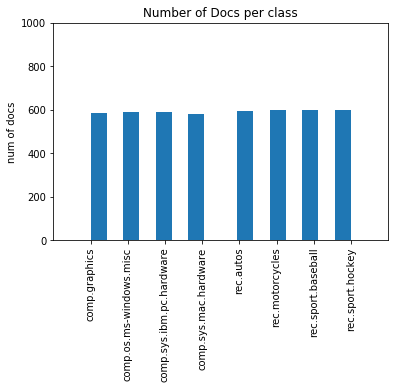

In [5]:
plt.hist(eight_train.target, bins = 16, align = 'mid')
plt.title('Number of Docs per class')
plt.ylabel('num of docs')
plt.xticks(range(8),categories,rotation = 90)
plt.xlim([-1,8])
plt.ylim([0,1000])
plt.show()


# Problem b

In [19]:
print ("Final Number of Terms Extracted :" + str(count_min_df_2.shape[1]))
print ("Final Number of Terms Extracted :" + str(count_min_df_5.shape[1]))

Final Number of Terms Extracted :21842
Final Number of Terms Extracted :8928


# Problem c

In [9]:
twenty_train = fetch_20newsgroups(subset='train')
twenty_train_target = twenty_train.target_names  # extract all the class names


allwords = []
# organize words in 20 categories of data in one matrix
for counter in range(20):
    allwords.append("")
for index in range(len(twenty_train.data)):
    category = twenty_train.target[index]
    allwords[category] = allwords[category] + " " + twenty_train.data[index]
    

#After stemming and tokenizing, performing tficf    
allwords_count_min_df_2 = count_vectorizer_min_df_2.fit_transform(allwords)
allwords_tficf = tfidf_transformer.fit_transform(allwords_count_min_df_2)

index_ibm = twenty_train_target.index("comp.sys.ibm.pc.hardware")
index_mac = twenty_train_target.index("comp.sys.mac.hardware")
index_forsale = twenty_train_target.index("misc.forsale")
index_christian = twenty_train_target.index("soc.religion.christian")

most_significant_words_ibm = ten_most_significant_terms(index_ibm)
most_significant_words_mac = ten_most_significant_terms(index_mac)
most_significant_words_forsale = ten_most_significant_terms(index_forsale)
most_significant_words_christian = ten_most_significant_terms(index_christian)

print("10 most significant terms for comp.sys.ibm.pc.hardware", most_significant_words_ibm)
print("10 most significant terms for comp.sys.mac.hardware", most_significant_words_mac)
print("10 most significant terms for misc.forsale", most_significant_words_forsale)
print("10 most significant terms for soc.religion.christian", most_significant_words_christian)

10 most significant terms for comp.sys.ibm.pc.hardware ['control', 'card', 'organ', 'subject', 'line', 'use', 'ide', 'thi', 'scsi', 'drive']
10 most significant terms for comp.sys.mac.hardware ['problem', 'appl', 'simm', 'quadra', 'use', 'organ', 'subject', 'mac', 'line', 'thi']
10 most significant terms for misc.forsale ['use', 'new', 'thi', 'univers', '2', 'organ', 'sale', '1', 'subject', 'line']
10 most significant terms for soc.religion.christian ['line', 'peopl', 'subject', 'church', 'hi', 'jesu', 'christian', 'wa', 'god', 'thi']


# Problem d

In [20]:
# See Dimension Reduction Process in Classification Preparation Section

# Problem e

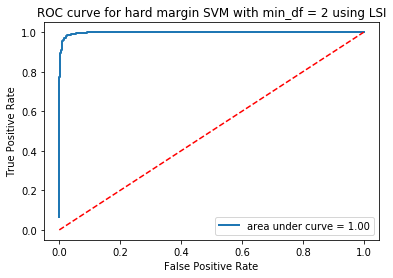

confusion matrix
[[1515   45]
 [  24 1566]]
accuracy = 0.978095238095
precision = 0.972067039106
recall = 0.984905660377
(3150, 21842)
(4732, 50)
(4732,)
(3150,)
(3150,)


In [57]:
#performing hard margin SVM classifier for min_df = 2 using LSI

input_train_data = eight_train_tfidf_min_df_2_lsa
input_test_data = eight_test_tfidf_min_df_2_lsa
classifier = SVC(C = 1000, kernel='linear',probability = True)
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for hard margin SVM with min_df = 2 using LSI'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

print(eight_test_tfidf_min_df_2.shape)
print(input_train_data.shape)
print(eight_train_target.shape)
print(eight_test_target.shape)
print(predicted_data.shape)



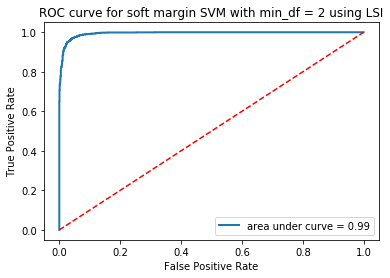

confusion matrix
[[   0 1560]
 [   0 1590]]
accuracy = 0.504761904762
precision = 0.504761904762
recall = 1.0


In [58]:
#performing soft margin SVM classifier for min_df = 2 using LSI
input_train_data = eight_train_tfidf_min_df_2_lsa
input_test_data = eight_test_tfidf_min_df_2_lsa
classifier = SVC(C = 0.001, kernel = 'linear', probability = True)
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for soft margin SVM with min_df = 2 using LSI'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

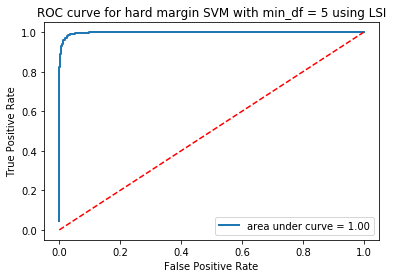

confusion matrix
[[1516   44]
 [  25 1565]]
accuracy = 0.978095238095
precision = 0.97265382225
recall = 0.98427672956


In [59]:
#performing hard margin SVM classifier for min_df = 5 using LSI
input_train_data = eight_train_tfidf_min_df_5_lsa
input_test_data = eight_test_tfidf_min_df_5_lsa
classifier = SVC(C = 1000, kernel = 'linear', probability = True)
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for hard margin SVM with min_df = 5 using LSI'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

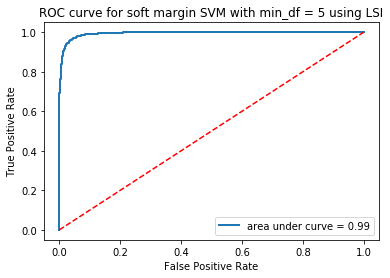

confusion matrix
[[   0 1560]
 [   0 1590]]
accuracy = 0.504761904762
precision = 0.504761904762
recall = 1.0


In [60]:
#performing soft margin SVM classifier for min_df = 5 using LSI
input_train_data = eight_train_tfidf_min_df_5_lsa
input_test_data = eight_test_tfidf_min_df_5_lsa
classifier = SVC(C = 0.001, kernel = 'linear', probability = True)
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for soft margin SVM with min_df = 5 using LSI'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

# Problem F

In [105]:
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     'kernel' : ['linear'], 
     'probability' : [True]}
]

input_train_data = eight_train_tfidf_min_df_2_lsa
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_2_lsa

results = tunning_parameters(SVC(), param_grid, input_train_data, input_train_target)
#predicted_prob = grid.predict_proba(input_test_data)[:,1]
#predicted_data = classifier.predict(input_test_data)

#roc_title = 'ROC curve for soft margin SVM with min_df = 5 using LSI'
#plot_roc_curve(eight_test_target, predicted_prob, roc_title)
#compute_prediction_stats(eight_test_target, predicted_data)

# Tuning hyper-parameters for accuracy
{'C': 1000, 'kernel': 'linear', 'probability': True}

Grid scores on development set:

0.505 (+/-0.000) for {'C': 0.001, 'kernel': 'linear', 'probability': True}
0.506 (+/-0.001) for {'C': 0.01, 'kernel': 'linear', 'probability': True}
0.967 (+/-0.011) for {'C': 0.1, 'kernel': 'linear', 'probability': True}
0.974 (+/-0.010) for {'C': 1, 'kernel': 'linear', 'probability': True}
0.974 (+/-0.009) for {'C': 10, 'kernel': 'linear', 'probability': True}
0.976 (+/-0.009) for {'C': 100, 'kernel': 'linear', 'probability': True}
0.976 (+/-0.011) for {'C': 1000, 'kernel': 'linear', 'probability': True}



In [102]:
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     'kernel' : ['linear'], 
     'probability' : [True]}
]
input_train_data = eight_train_tfidf_min_df_2_nmf
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_2_nmf

results = tunning_parameters(SVC(), param_grid, input_train_data, input_train_target)

# Tuning hyper-parameters for accuracy
{'C': 100, 'kernel': 'linear', 'probability': True}

Grid scores on development set:

0.505 (+/-0.000) for {'C': 0.001, 'kernel': 'linear', 'probability': True}
0.505 (+/-0.000) for {'C': 0.01, 'kernel': 'linear', 'probability': True}
0.505 (+/-0.000) for {'C': 0.1, 'kernel': 'linear', 'probability': True}
0.954 (+/-0.011) for {'C': 1, 'kernel': 'linear', 'probability': True}
0.973 (+/-0.006) for {'C': 10, 'kernel': 'linear', 'probability': True}
0.975 (+/-0.006) for {'C': 100, 'kernel': 'linear', 'probability': True}
0.975 (+/-0.006) for {'C': 1000, 'kernel': 'linear', 'probability': True}



In [100]:
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     'kernel' : ['linear'], 
     'probability' : [True]}
]
input_train_data = eight_train_tfidf_min_df_5_lsa
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_5_lsa

results = tunning_parameters(SVC(), param_grid, input_train_data, input_train_target)

# Tuning hyper-parameters for accuracy
{'C': 1000, 'kernel': 'linear', 'probability': True}

Grid scores on development set:

0.505 (+/-0.000) for {'C': 0.001, 'kernel': 'linear', 'probability': True}
0.511 (+/-0.004) for {'C': 0.01, 'kernel': 'linear', 'probability': True}
0.965 (+/-0.011) for {'C': 0.1, 'kernel': 'linear', 'probability': True}
0.972 (+/-0.005) for {'C': 1, 'kernel': 'linear', 'probability': True}
0.974 (+/-0.011) for {'C': 10, 'kernel': 'linear', 'probability': True}
0.974 (+/-0.014) for {'C': 100, 'kernel': 'linear', 'probability': True}
0.975 (+/-0.011) for {'C': 1000, 'kernel': 'linear', 'probability': True}



# Problem g

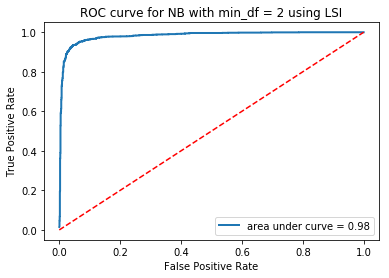

confusion matrix
[[1048  512]
 [  18 1572]]
accuracy = 0.831746031746
precision = 0.754318618042
recall = 0.988679245283


In [106]:
#performing NB classifier for min_df = 2 using LSI
input_train_data = eight_train_tfidf_min_df_2_lsa
input_test_data = eight_test_tfidf_min_df_2_lsa
classifier = GaussianNB()
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for NB with min_df = 2 using LSI'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

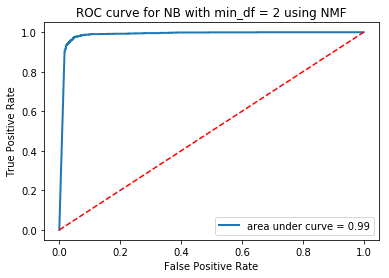

confusion matrix
[[1450  110]
 [  27 1563]]
accuracy = 0.956507936508
precision = 0.934249850568
recall = 0.983018867925


In [108]:
#performing NB classifier for min_df = 2 using NMF
input_train_data = eight_train_tfidf_min_df_2_nmf
input_test_data = eight_test_tfidf_min_df_2_nmf
classifier = GaussianNB()
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for NB with min_df = 2 using NMF'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

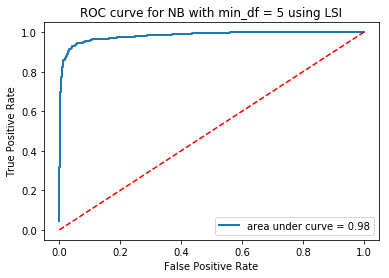

confusion matrix
[[1157  403]
 [  32 1558]]
accuracy = 0.861904761905
precision = 0.794492605813
recall = 0.979874213836


In [109]:
#performing NB classifier for min_df = 5 using LSI
input_train_data = eight_train_tfidf_min_df_5_lsa
input_test_data = eight_test_tfidf_min_df_5_lsa
classifier = GaussianNB()
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for NB with min_df = 5 using LSI'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

# Problem h

## min_df = 2

### LSI

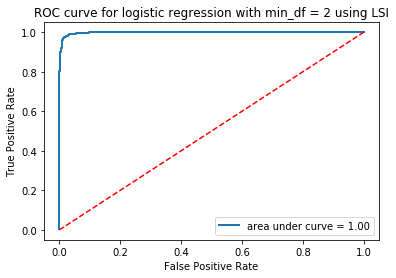

confusion matrix
[[1510   50]
 [  23 1567]]
accuracy = 0.976825396825
precision = 0.969078540507
recall = 0.985534591195


In [87]:
#performing logistic regression classifier for min_df = 2 using LSI
input_train_data = eight_train_tfidf_min_df_2_lsa
input_test_data = eight_test_tfidf_min_df_2_lsa

classifier = LogisticRegression(C = 10000)
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for logistic regression with min_df = 2 using LSI'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

### NMF

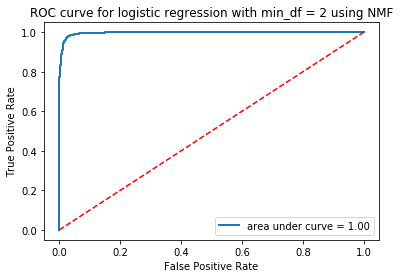

confusion matrix
[[1497   63]
 [  21 1569]]
accuracy = 0.973333333333
precision = 0.961397058824
recall = 0.98679245283


In [88]:
#performing logistic regression classifier for min_df = 2 using NMF
input_train_data = eight_train_tfidf_min_df_2_nmf
input_test_data = eight_test_tfidf_min_df_2_nmf

classifier = LogisticRegression(C = 10000)
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for logistic regression with min_df = 2 using NMF'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

## min_df = 5

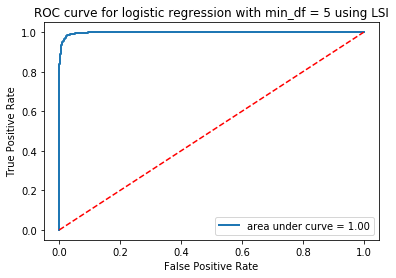

confusion matrix
[[1512   48]
 [  24 1566]]
accuracy = 0.977142857143
precision = 0.970260223048
recall = 0.984905660377


In [89]:
#performing logistic regression classifier for min_df = 5 using LSI
input_train_data = eight_train_tfidf_min_df_5_lsa
input_test_data = eight_test_tfidf_min_df_5_lsa
classifier = LogisticRegression(C = 10000)
classifier = classifier.fit(input_train_data, eight_train_target)

predicted_prob = classifier.predict_proba(input_test_data)[:,1]
predicted_data = classifier.predict(input_test_data)

roc_title = 'ROC curve for logistic regression with min_df = 5 using LSI'
plot_roc_curve(eight_test_target, predicted_prob, roc_title)
compute_prediction_stats(eight_test_target, predicted_data)

# Problem i

## Penalty = 'l1'

In [97]:
param_grid = [
    {'penalty' : ['l1'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

input_train_data = eight_train_tfidf_min_df_2_lsa
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_2_lsa

results = tunning_parameters(LogisticRegression(), param_grid, input_train_data, input_train_target)

# Tuning hyper-parameters for accuracy
{'C': 10, 'penalty': 'l1'}

Grid scores on development set:

0.495 (+/-0.000) for {'C': 0.001, 'penalty': 'l1'}
0.922 (+/-0.030) for {'C': 0.01, 'penalty': 'l1'}
0.942 (+/-0.016) for {'C': 0.1, 'penalty': 'l1'}
0.971 (+/-0.005) for {'C': 1, 'penalty': 'l1'}
0.977 (+/-0.009) for {'C': 10, 'penalty': 'l1'}
0.976 (+/-0.010) for {'C': 100, 'penalty': 'l1'}
0.976 (+/-0.009) for {'C': 1000, 'penalty': 'l1'}



In [96]:
param_grid = [
    {'penalty' : ['l1'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

input_train_data = eight_train_tfidf_min_df_2_nmf
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_2_nmf

results = tunning_parameters(LogisticRegression(), param_grid, input_train_data, input_train_target)

# Tuning hyper-parameters for accuracy
{'C': 10, 'penalty': 'l1'}

Grid scores on development set:

0.495 (+/-0.000) for {'C': 0.001, 'penalty': 'l1'}
0.495 (+/-0.000) for {'C': 0.01, 'penalty': 'l1'}
0.564 (+/-0.078) for {'C': 0.1, 'penalty': 'l1'}
0.967 (+/-0.007) for {'C': 1, 'penalty': 'l1'}
0.975 (+/-0.008) for {'C': 10, 'penalty': 'l1'}
0.974 (+/-0.007) for {'C': 100, 'penalty': 'l1'}
0.974 (+/-0.010) for {'C': 1000, 'penalty': 'l1'}



In [95]:
param_grid = [
    {'penalty' : ['l1'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

input_train_data = eight_train_tfidf_min_df_5_lsa
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_5_lsa

results = tunning_parameters(LogisticRegression(), param_grid, input_train_data, input_train_target)

# Tuning hyper-parameters for accuracy
{'C': 1000, 'penalty': 'l1'}

Grid scores on development set:

0.495 (+/-0.000) for {'C': 0.001, 'penalty': 'l1'}
0.932 (+/-0.022) for {'C': 0.01, 'penalty': 'l1'}
0.942 (+/-0.011) for {'C': 0.1, 'penalty': 'l1'}
0.971 (+/-0.005) for {'C': 1, 'penalty': 'l1'}
0.974 (+/-0.013) for {'C': 10, 'penalty': 'l1'}
0.974 (+/-0.013) for {'C': 100, 'penalty': 'l1'}
0.975 (+/-0.014) for {'C': 1000, 'penalty': 'l1'}



## Penalty = 'l2'

In [93]:
param_grid = [
    {
        'penalty' : ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

input_train_data = eight_train_tfidf_min_df_2_lsa
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_2_lsa

results = tunning_parameters(LogisticRegression(), param_grid, input_train_data, input_train_target)

# Tuning hyper-parameters for accuracy
{'C': 100, 'penalty': 'l2'}

Grid scores on development set:

0.717 (+/-0.022) for {'C': 0.001, 'penalty': 'l2'}
0.949 (+/-0.005) for {'C': 0.01, 'penalty': 'l2'}
0.966 (+/-0.011) for {'C': 0.1, 'penalty': 'l2'}
0.970 (+/-0.009) for {'C': 1, 'penalty': 'l2'}
0.975 (+/-0.008) for {'C': 10, 'penalty': 'l2'}
0.977 (+/-0.008) for {'C': 100, 'penalty': 'l2'}
0.977 (+/-0.010) for {'C': 1000, 'penalty': 'l2'}



In [94]:
param_grid = [
    {'penalty' : ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
]

input_train_data = eight_train_tfidf_min_df_2_nmf
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_2_nmf

results = tunning_parameters(LogisticRegression(), param_grid, input_train_data, input_train_target)

# Tuning hyper-parameters for accuracy
{'C': 1000, 'penalty': 'l2'}

Grid scores on development set:

0.505 (+/-0.000) for {'C': 0.001, 'penalty': 'l2'}
0.517 (+/-0.003) for {'C': 0.01, 'penalty': 'l2'}
0.891 (+/-0.010) for {'C': 0.1, 'penalty': 'l2'}
0.955 (+/-0.011) for {'C': 1, 'penalty': 'l2'}
0.968 (+/-0.008) for {'C': 10, 'penalty': 'l2'}
0.973 (+/-0.008) for {'C': 100, 'penalty': 'l2'}
0.976 (+/-0.006) for {'C': 1000, 'penalty': 'l2'}



In [101]:
param_grid = [
    {'penalty' : ['l2'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
]

input_train_data = eight_train_tfidf_min_df_5_lsa
input_train_target = eight_train_target
input_test_data = eight_test_tfidf_min_df_5_lsa

results = tunning_parameters(LogisticRegression(), param_grid, input_train_data, input_train_target)

# Tuning hyper-parameters for accuracy
{'C': 100, 'penalty': 'l2'}

Grid scores on development set:

0.770 (+/-0.017) for {'C': 0.001, 'penalty': 'l2'}
0.952 (+/-0.006) for {'C': 0.01, 'penalty': 'l2'}
0.965 (+/-0.011) for {'C': 0.1, 'penalty': 'l2'}
0.970 (+/-0.009) for {'C': 1, 'penalty': 'l2'}
0.973 (+/-0.009) for {'C': 10, 'penalty': 'l2'}
0.974 (+/-0.011) for {'C': 100, 'penalty': 'l2'}
0.974 (+/-0.013) for {'C': 1000, 'penalty': 'l2'}



# Multiclass Classification:
## Problem j

In [113]:
# Extract datasets
categories = ['comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware',
              'misc.forsale',
              'soc.religion.christian']

train_data = fetch_20newsgroups(subset='train', 
                                categories=categories, 
                                shuffle=True, 
                                random_state=42)
test_data = fetch_20newsgroups(subset='test', 
                               categories=categories, 
                               shuffle=True, 
                               random_state=42)


### Naive Bayes Classification

In [129]:
pipeline = Pipeline([
    ('vect', count_vectorizer_min_df_2),
    ('tfidf', tfidf_transformer),
    ('svd', lsa_model),
    ('clf', GaussianNB())
])


pipeline = pipeline.fit(train_data.data, train_data.target)

predicted_prob = pipeline.predict_proba(test_data.data)[:,1]
predicted_data = pipeline.predict(test_data.data)

#roc_title = 'ROC curve for hard margin SVM with min_df = 2 using LSI'
#plot_roc_curve(test_data.target, predicted_prob, roc_title)
compute_prediction_stats(test_data.target, predicted_data, isBinary=False)

confusion matrix
[[232  27 128   5]
 [ 88 159 136   2]
 [ 46  21 320   3]
 [  0   0  26 372]]
accuracy = 0.692012779553
precision = 0.692012779553
recall = 0.692012779553


In [130]:
pipeline = Pipeline([
    ('vect', count_vectorizer_min_df_2),
    ('tfidf', tfidf_transformer),
    ('svd', nmf_model),
    ('clf', GaussianNB())
])


pipeline = pipeline.fit(train_data.data, train_data.target)

predicted_prob = pipeline.predict_proba(test_data.data)[:,1]
predicted_data = pipeline.predict(test_data.data)

#roc_title = 'ROC curve for hard margin SVM with min_df = 2 using LSI'
#plot_roc_curve(test_data.target, predicted_prob, roc_title)
compute_prediction_stats(test_data.target, predicted_data, isBinary=False)

confusion matrix
[[302  32  54   4]
 [ 78 256  50   1]
 [ 59  17 310   4]
 [  4   0   6 388]]
accuracy = 0.802555910543
precision = 0.802555910543
recall = 0.802555910543


### Multiclass SVM
#### One vs One

In [124]:
#input_train_data = eight_train_tfidf_min_df_2_lsa
#input_test_data = eight_test_tfidf_min_df_2_lsa

clf = SVC(C=1000, 
          kernel='linear', 
          probability=True, 
          decision_function_shape='ovo')
pipeline = Pipeline([
    ('vect', count_vectorizer_min_df_2),
    ('tfidf', tfidf_transformer),
    ('svd', lsa_model),
    ('clf', clf)
])


pipeline = pipeline.fit(train_data.data, train_data.target)

predicted_prob = pipeline.predict_proba(test_data.data)[:,1]
predicted_data = pipeline.predict(test_data.data)

#roc_title = 'ROC curve for hard margin SVM with min_df = 2 using LSI'
#plot_roc_curve(test_data.target, predicted_prob, roc_title)
compute_prediction_stats(test_data.target, predicted_data, isBinary=False)

confusion matrix
[[332  36  24   0]
 [ 46 316  23   0]
 [ 29  14 347   0]
 [  7   0   3 388]]
accuracy = 0.883706070288
precision = 0.883706070288
recall = 0.883706070288


In [126]:
clf = SVC(C=1000, 
          kernel='linear', 
          probability=True, 
          decision_function_shape='ovo')
pipeline = Pipeline([
    ('vect', count_vectorizer_min_df_2),
    ('tfidf', tfidf_transformer),
    ('svd', nmf_model),
    ('clf', clf)
])


pipeline = pipeline.fit(train_data.data, train_data.target)

predicted_prob = pipeline.predict_proba(test_data.data)[:,1]
predicted_data = pipeline.predict(test_data.data)

#roc_title = 'ROC curve for hard margin SVM with min_df = 2 using LSI'
#plot_roc_curve(test_data.target, predicted_prob, roc_title)
compute_prediction_stats(test_data.target, predicted_data, isBinary=False)

confusion matrix
[[335  42  15   0]
 [ 66 296  23   0]
 [ 30  13 345   2]
 [  8   0   3 387]]
accuracy = 0.870926517572
precision = 0.870926517572
recall = 0.870926517572


#### One vs the Rest

In [125]:
clf = SVC(C=1000, 
          kernel='linear', 
          probability=True, 
          decision_function_shape='ovr')
pipeline = Pipeline([
    ('vect', count_vectorizer_min_df_2),
    ('tfidf', tfidf_transformer),
    ('svd', lsa_model),
    ('clf', clf)
])


pipeline = pipeline.fit(train_data.data, train_data.target)

predicted_prob = pipeline.predict_proba(test_data.data)[:,1]
predicted_data = pipeline.predict(test_data.data)

#roc_title = 'ROC curve for hard margin SVM with min_df = 2 using LSI'
#plot_roc_curve(test_data.target, predicted_prob, roc_title)
compute_prediction_stats(test_data.target, predicted_data, isBinary=False)

confusion matrix
[[332  36  24   0]
 [ 46 316  23   0]
 [ 29  14 347   0]
 [  7   0   3 388]]
accuracy = 0.883706070288
precision = 0.883706070288
recall = 0.883706070288


In [127]:
clf = SVC(C=1000, 
          kernel='linear', 
          probability=True, 
          decision_function_shape='ovr')
pipeline = Pipeline([
    ('vect', count_vectorizer_min_df_2),
    ('tfidf', tfidf_transformer),
    ('svd', nmf_model),
    ('clf', clf)
])


pipeline = pipeline.fit(train_data.data, train_data.target)

predicted_prob = pipeline.predict_proba(test_data.data)[:,1]
predicted_data = pipeline.predict(test_data.data)

#roc_title = 'ROC curve for hard margin SVM with min_df = 2 using LSI'
#plot_roc_curve(test_data.target, predicted_prob, roc_title)
compute_prediction_stats(test_data.target, predicted_data, isBinary=False)

confusion matrix
[[335  42  15   0]
 [ 66 296  23   0]
 [ 30  13 345   2]
 [  8   0   3 387]]
accuracy = 0.870926517572
precision = 0.870926517572
recall = 0.870926517572
